# Data augmentation

In [1]:
from chapter import *

MNIST is too nice to be representative of real-world datasets. Below we continue with a more realistic Kaggle dataset, [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data). The task is to detect metastatic cancer in patches of images from digital pathology scans.
Download the dataset such that the folder structure looks as follows:

```
./data/histopathologic-cancer-detection
├── test
├── train
└── train_labels.csv
```

Taking a look at the first few images:

In [2]:
%%save
import cv2

IMG_DATASET_DIR = DATASET_DIR / "histopathologic-cancer-detection"
data = pd.read_csv(IMG_DATASET_DIR / "train_labels.csv")

import cv2

IMG_DATASET_DIR = DATASET_DIR / "histopathologic-cancer-detection"
data = pd.read_csv(IMG_DATASET_DIR / "train_labels.csv")

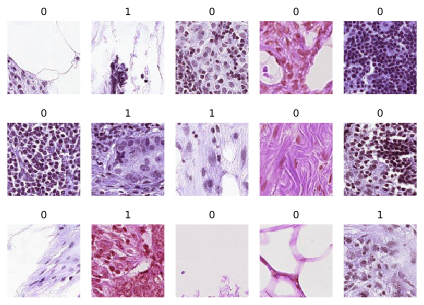

In [3]:
fig, ax = plt.subplots(3, 5, figsize=(6, 4.5))
for k in range(15):
    i, j = divmod(k, 5)
    fname = str(IMG_DATASET_DIR / "train" / f"{data.id[k]}.tif")
    ax[i, j].imshow(cv2.imread(fname))
    ax[i, j].set_title(data.label[k], size=10)
    ax[i, j].axis("off")
fig.tight_layout()

A positive label indicates that the center 32 × 32 region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

## Stochastic transforms

Data augmentation incorporates transformed or perturbed versions of the original images into the dataset. More precisely, each data point
$(\boldsymbol{\mathsf{x}}, y)$ in a mini-batch is replaced by $(T(\boldsymbol{\mathsf{x}}), y)$ during training
where $T$ is a stochastic label preserving transformation. At inference, an input $\boldsymbol{\mathsf{x}}$ is replaced by $\mathbb{E}[T(\boldsymbol{\mathsf{x}})].$

In [4]:
%%save
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.CenterCrop([49, 49]),
])

transform_infer = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop([49, 49]),
])

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.CenterCrop([49, 49]),
])

transform_infer = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop([49, 49]),
])

Since only the central pixels affect the labels by design, we use center crop. Furthermore, we know tissue samples in the slides can be flipped horizontally and vertically, as well as rotated (set to $\pm 20^{\circ}$ above) without affecting the actual presence of tumor tissue.

In [5]:
%%save
from torch.utils.data import DataLoader, Dataset, Subset

class HistopathologicDataset(Dataset):
    def __init__(self, data, train=True, transform=None):
        split = "train" if train else "test"
        self.fnames = [str(IMG_DATASET_DIR / split / f"{fn}.tif") for fn in data.id]
        self.labels = data.label.tolist()
        self.transform = transform
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, index):
        img = cv2.imread(self.fnames[index])
        if self.transform:
            img = self.transform(img)
        
        return img, self.labels[index]


data = data.sample(frac=1.0)
split = int(0.80 * len(data))
ds_train = HistopathologicDataset(data[:split], train=True, transform=transform_train)
ds_valid = HistopathologicDataset(data[split:], train=True, transform=transform_infer)

from torch.utils.data import DataLoader, Dataset, Subset

class HistopathologicDataset(Dataset):
    def __init__(self, data, train=True, transform=None):
        split = "train" if train else "test"
        self.fnames = [str(IMG_DATASET_DIR / split / f"{fn}.tif") for fn in data.id]
        self.labels = data.label.tolist()
        self.transform = transform
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, index):
        img = cv2.imread(self.fnames[index])
        if self.transform:
            img = self.transform(img)
        
        return img, self.labels[index]


data = data.sample(frac=1.0)
split = int(0.80 * len(data))
ds_train = HistopathologicDataset(data[:split], train=True, transform=transform_train)
ds_valid = HistopathologicDataset(data[split:], train=True, transform=transform_infer)

Some imbalance (not too severe):

In [6]:
# percentage of positive class
data[:split].label.mean(), data[split:].label.mean()

(0.4050562436086808, 0.4049312578116123)

Simulating images across epochs:

In [7]:
simul_train = DataLoader(Subset(ds_train, torch.arange(3)), batch_size=3, shuffle=True)
simul_valid = DataLoader(Subset(ds_valid, torch.arange(1)), batch_size=1, shuffle=False)

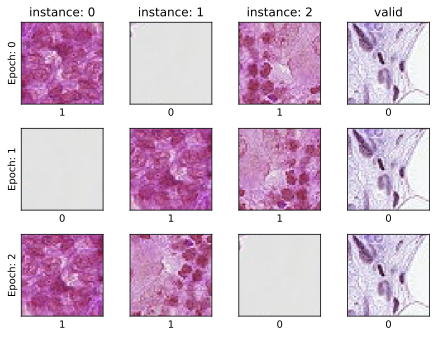

In [8]:
fig, ax = plt.subplots(3, 4)
for e in range(3):
    img_train, tgt_train = next(iter(simul_train))
    for i in range(3):
        if i == 0:
            ax[e, i].set_ylabel(f"Epoch: {e}")
        
        img, tgt = img_train[i], tgt_train[i]
        ax[e, i].imshow(img.permute(1, 2, 0).detach())
        ax[e, i].set_xlabel(tgt.item())
        ax[e, i].set_xticks([])
        ax[e, i].set_yticks([])
        ax[0, i].set_title(f"instance: {i}")

    img_valid, tgt_valid = next(iter(simul_valid))
    ax[e, 3].set_xlabel(tgt_valid[0].item())
    ax[e, 3].imshow(img_valid[0].permute(1, 2, 0).detach())
    ax[e, 3].set_xticks([])
    ax[e, 3].set_yticks([])

ax[0, 3].set_title("valid")
fig.tight_layout()

**Figure.** Training instances are stochastically transformed at each epoch. Meanwhile, test instances  have fixed transformations, i.e. the expectation of the random transformations.
Note that labels are not affected (both at the recognition and implementation level).